In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

#torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0606'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [15]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas_fld*.pth')]
len(model_wt_fnames), model_wt_fnames[:5]

(103,
 ['haha_clas_fld0_284178.pth',
  'haha_clas_fld0_860617.pth',
  'haha_clas_fld0_763992.pth',
  'haha_clas_fld2_478392.pth',
  'haha_clas_fld2_301875.pth'])

In [5]:
!grep Clas ./prod/out_fwd_tmp100.txt > ./by_seed_fwd_perf

In [13]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_fwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,acc,F1,rnd_seed,nfold
0,Clas Fold: 0 RndSeed: 301875,0.857292,0.822003,301875,0
1,Clas Fold: 1 RndSeed: 301875,0.868125,0.830990,301875,1
2,Clas Fold: 2 RndSeed: 301875,0.870833,0.835182,301875,2
3,Clas Fold: 3 RndSeed: 301875,0.865417,0.824456,301875,3
4,Clas Fold: 4 RndSeed: 301875,0.853750,0.824412,301875,4


Text(0.5, 1.0, 'Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

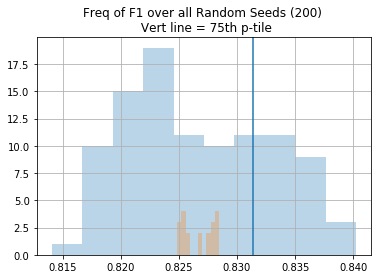

In [22]:
valid_perf.F1.hist(alpha=0.3)
valid_perf.groupby('rnd_seed')['F1'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.F1.quantile(0.75))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

In [29]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['F1'].mean()
selected_seeds = seed_grouped_F1[seed_grouped_F1>seed_grouped_F1.quantile(0.75)].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_clas_fld{fold}_{seed}.pth')

In [44]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [45]:
np.array(ensemble_preds).shape

(25, 6000, 2)

In [46]:
np.array(ensemble_preds)

array([[[0.262402, 0.737598],
        [0.94227 , 0.05773 ],
        [0.088907, 0.911093],
        [0.917108, 0.082892],
        ...,
        [0.429084, 0.570916],
        [0.897227, 0.102773],
        [0.433888, 0.566112],
        [0.200117, 0.799883]],

       [[0.131651, 0.868349],
        [0.889234, 0.110765],
        [0.061619, 0.938381],
        [0.944622, 0.055378],
        ...,
        [0.401831, 0.598169],
        [0.879978, 0.120022],
        [0.272876, 0.727124],
        [0.198984, 0.801016]],

       [[0.225891, 0.774109],
        [0.88268 , 0.11732 ],
        [0.081785, 0.918215],
        [0.914088, 0.085912],
        ...,
        [0.71429 , 0.28571 ],
        [0.883511, 0.116489],
        [0.419171, 0.580829],
        [0.213234, 0.786766]],

       [[0.319825, 0.680175],
        [0.858617, 0.141383],
        [0.098251, 0.901749],
        [0.990269, 0.009731],
        ...,
        [0.557695, 0.442305],
        [0.823432, 0.176568],
        [0.638465, 0.361535],
        [0.2

In [47]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.200543, 0.799457],
       [0.865051, 0.134949],
       [0.073352, 0.926648],
       [0.911476, 0.088524],
       ...,
       [0.507683, 0.492317],
       [0.873265, 0.126735],
       [0.425448, 0.574552],
       [0.204346, 0.795654]], dtype=float32)

In [48]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [49]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [50]:
out_df.to_csv('sub0608_finetune.csv',header=True,index=False)